## Логистическая регрессия

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

Для начала несколько теоретическиз выкладок.

Для начала 
$$a(x) = w_0 + \sum_{i=1}^{d} (w_i*x_i)$$

или введя x_0=1:

$$a(x) = \sum_{i=0}^{d} (w_i*x_i)$$


Для предсказания при вычисленных весах используется сигмоида:

$$s(a)=1/(1+e^{-z})$$

```
def sigmoid(z):
    return  1 / (1 + np.exp(-z))
```


y={0,1}

Возьмем ln от s:
$$ln(s)=-log(1+e^-<w, x>)$$

Тогда функция потерь будет ввидe:

$$J(w) = -1/m * \sum_{i=0}^{m} y_i*ln(s) + (1-y_i)*ln(1-s)$$

Которое упрощается до:

$$J(w) = -1/m * \sum_{i=0}^{m}*(y_i*<w, x> - ln(1+e^<w,x>))$$

Производная равна:

$$ \frac{\partial J}{\partial w^j} = -1/m * \sum_{i=0}^{m}*(x^j_i*(y_i-s(<w,x_i>)))$$

Переходим к формуле:

$$w_j = w_j - a/m* \sum_{i=0}^{m}*(s(w, x_i) - y_i)*x_i^j$$

Инициализируем с w=[0...0]


Источники:
http://wiki.fast.ai/index.php/Logistic_Regression#Linear_vs_Logistic

https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html


https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression


Сначала реализую и нарисую сигмоиду

In [111]:
def sigmoid(z):
    return  1 / (1 + np.exp(-z))

In [112]:
x=np.arange(-10, 10, 0.1)
y=sigmoid(x)

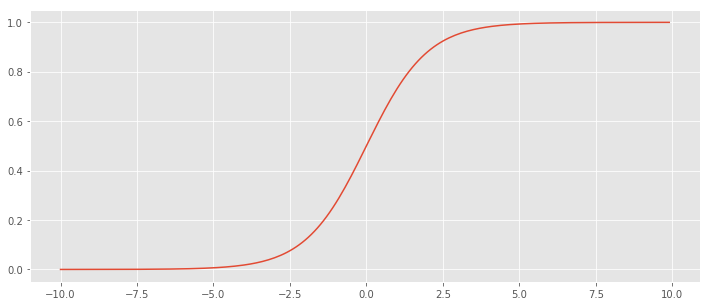

In [113]:
plt.plot(x, y)

Реализую функцию скалярного перемножения векторов и проверм ее работу

In [114]:
def scalar_multply(x, w):
    return np.dot(x, w)

In [115]:
scalar_multply(np.array([1,2]), np.array([3, 4]))

11

In [116]:
1*3+2*4

11

In [117]:
scalar_multply(np.array([[1,2], [3, 4]]), np.array([3, 4]))

array([11, 25])

In [118]:
np.unique

<function numpy.lib.arraysetops.unique(ar, return_index=False, return_inverse=False, return_counts=False, axis=None)>

Потренируемся добавлять свободный член в массив:

In [119]:
X  = np.array([[1,2],[3, 4]])

In [120]:
X

array([[1, 2],
       [3, 4]])

In [121]:
x = X.copy()

In [122]:
np.ones([len(x),1])

array([[1.],
       [1.]])

In [123]:
np.concatenate((x, np.ones([len(x), 1])), axis=1)

array([[1., 2., 1.],
       [3., 4., 1.]])

In [124]:
from collections import Counter

Теперь реализуем функцию для penalty

In [125]:
def get_penalty(w, penalty=None):
    if penalty is None:
        return 0
    #последний член является свободным и пенальти на нем назначать нельзя
    w_calc = w[:-1]
    if(penalty=='l2'):
        order =2
    elif(penalty =='l1'):
        order = 1
    return np.linalg.norm(w_calc, ord=order, axis=0)

In [126]:
get_penalty([1,2,3]), get_penalty(np.array([1,2,3]), penalty='l1'), get_penalty(np.array([1,2,3]), penalty='l2')

(0, 3.0, 2.23606797749979)

В качестве величины ошибки будет использоваться полная функция по всем данным

In [127]:
def J(w, X, y, penalty, C):
    y_pred = scalar_multply(X, w)
    y_pred = sigmoid(y_pred)
    j = -1/len(y)*np.sum(np.multiply(y, np.log(y_pred))+np.multiply(1-y, np.log(1-y_pred))) + C* get_penalty(w, penalty)
    return j

По-хорошему нам нужна производная. Для этого введем новую функцию:
- Для L1 регуляризации как производная с некоторым приближением можно возврашать знак
- Для L2 - 
$$1/||w|| * w$$

Для свободного члена - равен 0

In [128]:
def get_penalty_grad(w, penalty=None):
    if penalty is None:
        return 0
    
    w_calc = w[:-1]
    if penalty=='l1':
        return np.append(np.sign(w_calc), 0)
    if penalty=='l2':
        dist = np.linalg.norm(w_calc, ord=2, axis=0)
        if dist==0:
            return 0
        return 1/dist*(np.append(w_calc, 0))

Проверим

In [129]:
get_penalty_grad(np.array([1, 2,3]))

0

In [130]:
get_penalty_grad(np.array([-1, 2, -3, 0, 0]), penalty='l1')


array([-1,  1, -1,  0,  0])

In [131]:
get_penalty_grad(np.array([3, 4, 5]), penalty='l2')


array([0.6, 0.8, 0. ])

In [132]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier_old(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty='l2'):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.w_ = []
        assert penalty==None or penalty=='l1' or penalty=='l2', 'penalty must l1, l2 or None'
        self.penalty = penalty
    
    def check(self, X, y):
        '''
        Первичная проверка
        '''
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), 'X, y must ndarray'
        
        assert Counter(np.unique(y)) == Counter([0,1]), 'work only for two class'
        assert len(X)!=0 and len(X)==len(y)
    
    def prepare(self, X, y):
        '''
        Первичная подготовка
        '''
        #       скопируем данные из Х и добавим к нему свободный член равный 1.
        X = X.copy()
        X = np.concatenate((X, np.ones([len(X), 1])), axis=1)
#       считаем что y = 0 или 1         
        y = y.copy()
        return X, y
        
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self.check(X, y)
        self.error_=[]
        x, y = self.prepare(X, y)
        
        #инициализируем начальный вектор весов
        self.w_ = np.zeros(len(x[0]))
        
        self.do_SGD(x, y , self.w_)
        
        return self
    
    def do_SGD(self, x, y, w):
        '''
        Сам градиентный спуск
        '''
        # количество эпох
        for _ in range(self.max_epoch):
            #индекс в текущем расчете
            for i in np.random.choice(len(y), len(y), replace=False):
                d = scalar_multply(x[i], w)
                s = sigmoid(d)
                w = w - self.alpha*(x[i]*(s-y[i]) + self.C*get_penalty_grad(w, self.penalty))
            self.error_.append(J(w, x, y, self.penalty, self.C))
        self.w_ = w
        
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        self.check(X, y)
        x, y = self.prepare(X, y)
        
        self.do_SGD(x, y , self.w_)

        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        #возьмем предельное значение равное 0.5
        y_hat = self.predict_proba(X)>=0.5
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X, y = self.prepare(X, np.array([]))
        y_hat_proba =sigmoid(scalar_multply(X, self.w_))
        return y_hat_proba

In [249]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty='l2'):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.w_ = []
        assert penalty==None or penalty=='l1' or penalty=='l2', 'penalty must l1, l2 or None'
        self.penalty = penalty
    
    def check(self, X, y):
        '''
        Первичная проверка
        '''
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), 'X, y must ndarray'
        
        assert Counter(np.unique(y)) == Counter([0,1]), 'work only for two class'
        assert len(X)!=0 and len(X)==len(y)
    
    def prepare(self, X, y):
        '''
        Первичная подготовка
        '''
        #       скопируем данные из Х и добавим к нему свободный член равный 1.
        X = X.copy()
        X = np.concatenate((X, np.ones([len(X), 1])), axis=1)
#       считаем что y = 0 или 1         
        y = y.copy()
        return X, y
        
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self.check(X, y)
        self.error_=[]
        x, y = self.prepare(X, y)
        
        #инициализируем начальный вектор весов
        self.w_ = np.zeros(len(x[0]))
        
        self.do_SGD(x, y , self.w_)
        
        return self
    
    def do_SGD(self, x, y, w):
        '''
        Сам градиентный спуск
        
        w=w-a*(x*(y_predict-y)+c*penalty)
        
        Здесь видел различные наименования, например:
        
        w=w-a/c(x(y_predict-t)+penalty)
        - но так как они все описывают только метапараметры, 
        то принята формула выше
        
        y_predict=sigmoida(<x, w>)
        '''
        # количество эпох
        np.random.seed(0)
        for _ in range(self.max_epoch):
            #индекс в текущем расчете
            for i in np.random.choice(len(y), len(y), replace=False):
                d = self.scalar_multply(x[i], w)
                s = self.sigmoid(d)
                w = w - self.alpha*(x[i]*(s-y[i]) + self.C *
                                    self.get_penalty_grad(w))
            self.error_.append(self.get_log_loss(w, x, y))
        self.w_ = w
        
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        self.check(X, y)
        x, y = self.prepare(X, y)
        
        self.do_SGD(x, y , self.w_)

        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        #возьмем предельное значение равное 0.5
        y_hat = self.predict_proba(X)>=0.5
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X, y = self.prepare(X, np.array([]))
        y_hat_proba = self.sigmoid(self.scalar_multply(X, self.w_))
        return y_hat_proba

    def get_log_loss(self, w, X, y):
        '''
        Логарифмическая функция потерь
        '''
        y_pred = self.scalar_multply(X, w)
        y_pred = self.sigmoid(y_pred)
        j = -1/len(y)*np.sum(np.multiply(y, np.log(y_pred))+np.multiply(1-y, np.log(1-y_pred))) + self.C * self.get_penalty(w)
        return j

    def get_penalty_grad(self, w):
        '''
        Градиент от штрафа.
        Если penalty==None->
        l1 - для X<0 =-1,  для Х>0 =1, в случае X==0  с некоторым упрощением принято =0
        l2 - w/||w||. При этом если ||w||==0, то для упрощения возвращаем 0,
        хотя математически это не верно, но в качестве упрощения - вполне допустимо думаю,
        так как если все w=0 штраф давать нет смысла уже.
        '''
        penalty = self.penalty
        if penalty is None:
            return 0

        w_calc = w[:-1]
        if penalty=='l1':
            return np.append(np.sign(w_calc), 0)
        if penalty=='l2':
            dist = np.linalg.norm(w_calc, ord=2, axis=0)
            if dist==0:
                return 0
            return 1/dist*(np.append(w_calc, 0))
    
    def get_penalty(self, w):
        '''
        Расчет штрафов.
        Если penalty==None -> 0
        'l1' -> Сумма |w|  или нормализированное расстояние по степени 1
        'l2'->||w||
        
        Значение С не используется здесь
        '''
        penalty=self.penalty
        if penalty is None:
            return 0
        #последний член является свободным и пенальти на нем назначать нельзя
        w_calc = w[:-1]
        if(penalty=='l2'):
            order =2
        elif(penalty =='l1'):
            order = 1
        return np.linalg.norm(w_calc, ord=order, axis=0)

    def scalar_multply(self, x, w):
        '''
        Скалярное произведение. Вынесено отдельно больше для ясности.
        [[x1, x2],[x3, x4]] * [w1, w2] = [x1*w1+x2*w2, x3*w1+x4*w2]
        '''
        return np.dot(x, w)


    def sigmoid(self, z):
        '''
        Сигмоида. y=1/(1+e^(-z))
        '''
        return  1 / (1 + np.exp(-z))

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

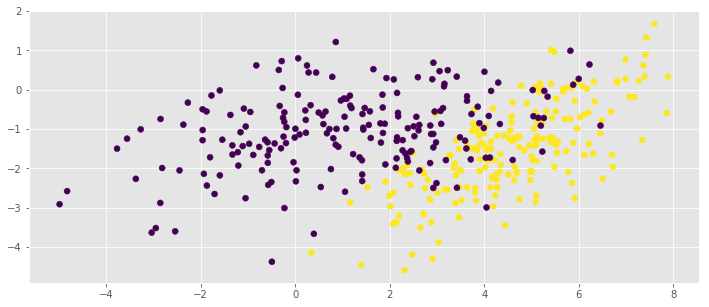

In [134]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [135]:
def plot_split_line(x, w, color = 'r'):
    y=(x*w[0]+w[-1])/(-w[1])
    plt.plot(x, y, c=color)

Для начала выполним расчет без регуляризации для того, чтобы проверить точность и сравним его с логистической регрессией из пакета sklearn

# Без штрафов

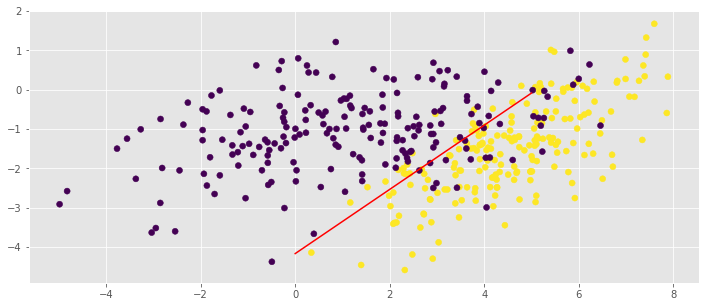

In [216]:
model = MySGDClassifier(max_epoch=100, penalty=None)
model.fit(X, y)
y_predict = model.predict(X)
plt.scatter(X[:,0], X[:,1], c=y)
plot_split_line(np.arange(0,6), model.w_)

In [217]:
model.w_

array([ 1.33617914, -1.63788894, -6.81688652])

In [218]:
from sklearn import metrics
metrics.accuracy_score(y, y_predict)

0.8775

Аккуратность - неплохая. Теперь sklearn

In [219]:
from sklearn.linear_model import SGDClassifier

In [220]:
clf = SGDClassifier(penalty=None, learning_rate='constant', max_iter=1000, eta0=0.01)

In [221]:
clf.fit(X, y)
y_predict = clf.predict(X)
metrics.accuracy_score(y, y_predict)

C:\app\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.88

In [222]:
clf.coef_, clf.intercept_

(array([[ 1.18813489, -1.25875222]]), array([-5.77]))

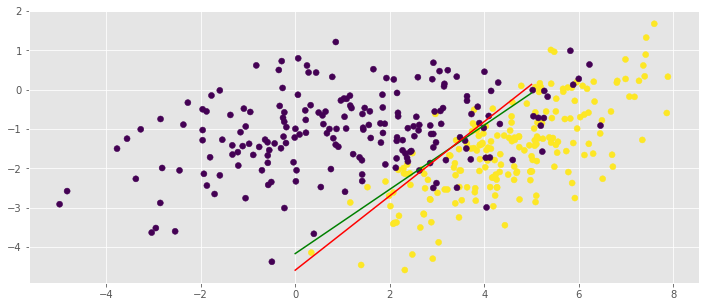

In [223]:
plt.scatter(X[:,0], X[:,1], c=y)
plot_split_line(np.arange(0,6), model.w_, color = 'green')
plot_split_line(np.arange(0,6), np.array([clf.coef_[0][0], clf.coef_[0][1] , clf.intercept_[0]]))

Значения довольно близки, с учетом случайности обучения. Теперь l2

# l2

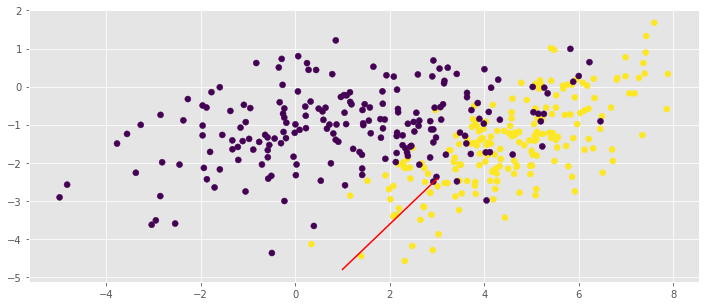

In [224]:
model = MySGDClassifier(max_epoch=100, penalty='l2')
model.fit(X, y)
y_predict = model.predict(X)
plt.scatter(X[:,0], X[:,1], c=y)
plot_split_line(np.arange(1, 4), model.w_)

In [225]:
model.w_

array([ 0.02732383, -0.02297515, -0.13764491])

In [226]:
metrics.accuracy_score(y, y_predict)

0.835

Как видно, оценка очень смещенная из-за большого C

In [227]:

clf = SGDClassifier(loss = 'log', penalty='l2', alpha=1, learning_rate='constant', max_iter=100, eta0=0.01)

In [228]:
clf.fit(X, y)
y_predict = clf.predict(X)
metrics.accuracy_score(y, y_predict)

C:\app\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.815

In [229]:
clf.coef_, clf.intercept_

(array([[ 0.28505161, -0.10191074]]), array([-1.21804422]))

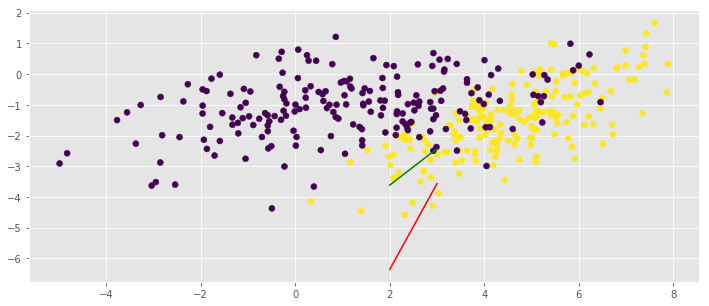

In [230]:
plt.scatter(X[:,0], X[:,1], c=y)
plot_split_line(np.arange(2,4), model.w_, color = 'green')
plot_split_line(np.arange(2,4), np.array([clf.coef_[0][0], clf.coef_[0][1] , clf.intercept_[0]]))

# l1

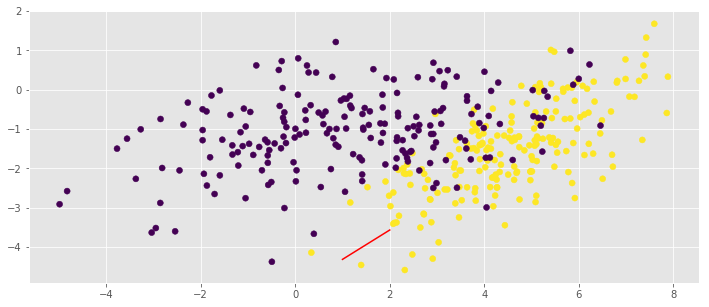

In [231]:
model = MySGDClassifier(max_epoch=100, penalty='l1')
model.fit(X, y)
y_predict = model.predict(X)
plt.scatter(X[:,0], X[:,1], c=y)
plot_split_line(np.arange(1, 3), model.w_)

In [232]:
model.w_

array([ 0.01707557, -0.02288205, -0.11567929])

In [233]:
metrics.accuracy_score(y, y_predict)

0.7

In [238]:
clf = SGDClassifier(loss = 'log', penalty='l1', alpha=0.8, learning_rate='constant', max_iter=100, eta0=0.01)

In [239]:
clf.fit(X, y)
y_predict = clf.predict(X)
metrics.accuracy_score(y, y_predict)

C:\app\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.7575

In [240]:
clf.coef_, clf.intercept_

(array([[0.01857774, 0.        ]]), array([-0.0772669]))

# Уменьшенные значения C

Теперь с меньшими значениями C - около 0.01

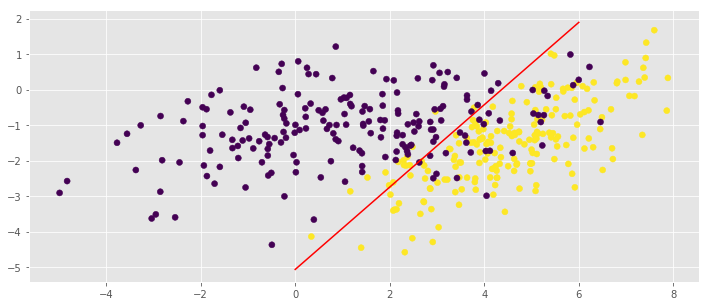

In [241]:
model = MySGDClassifier(max_epoch=100, penalty='l2', C=0.1)
model.fit(X, y)
y_predict = model.predict(X)
plt.scatter(X[:,0], X[:,1], c=y)
plot_split_line(np.arange(0,7), model.w_)

In [242]:
print(model.w_, metrics.accuracy_score(y, y_predict))


[ 0.8251829  -0.71125711 -3.60204337] 0.885


[ 0.73466255 -0.43639742 -2.83809229] 0.8775


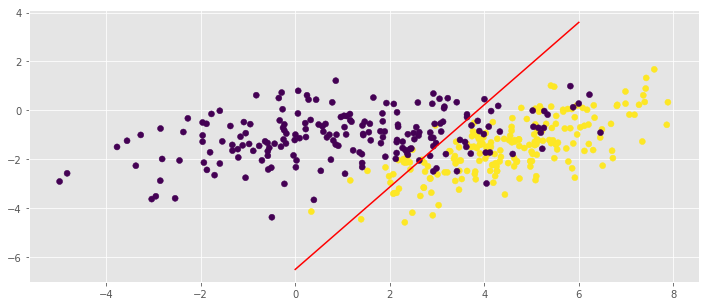

In [243]:
model = MySGDClassifier(max_epoch=100, penalty='l1', C=0.1)
model.fit(X, y)
y_predict = model.predict(X)
plt.scatter(X[:,0], X[:,1], c=y)
plot_split_line(np.arange(0,7), model.w_)
print(model.w_, metrics.accuracy_score(y, y_predict))


## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

Для анализа возьмем l2 регуляризацию с С=0.1.
Шаги - [0.005, 0.01, 0.05, 0.1]

In [244]:
step_alpha = [0.005, 0.01, 0.05, 0.1]

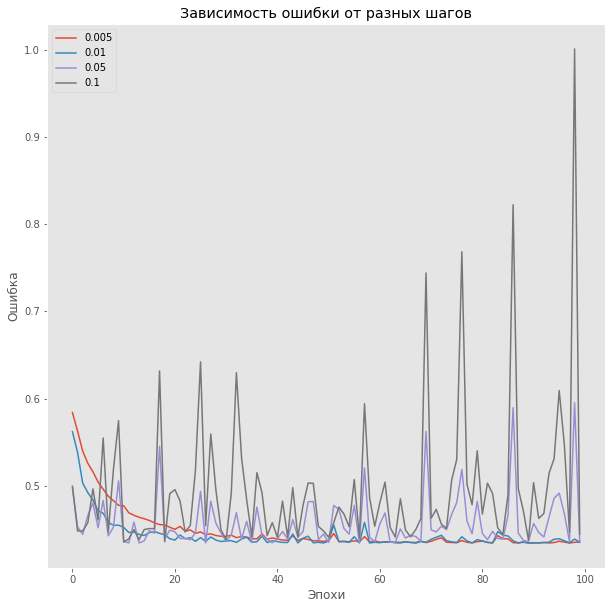

In [245]:
plt.figure(figsize=(10,10))
for alpha in step_alpha:
    model = MySGDClassifier(max_epoch=100, penalty='l2', C=0.1, alpha=alpha)
    model.fit(X, y)
    error = model.error_
    np.array(error)
    plt.plot(np.arange(len(error)), np.array(error), label = alpha)
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.title('Зависимость ошибки от разных шагов')
plt.grid()
plt.legend()

# Выводы

- С величиной регуляризатора надо очень аккуратно, а то получим странные решения
- l1 штрафует сильнее
- Шаги выбирать аккуратно, а то можем совсем не сойтись
- и лучше использовать sklearn, а не городить свои велосипеды)